# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Data Collection

health = pd.read_csv("D:SYB65_246_202209_Population Growth, Fertility and Mortality Indicators.csv")
blood = pd.read_csv("D:bloodtypes.csv")

health = health.iloc[28:,1:5]
health.columns = ['Country', 'Year', 'Factor','Value']
health = health.loc[health['Year'] == 2022]

pivoted_health = health.pivot_table(index=['Country', 'Year'], columns='Factor', values='Value').reset_index()

#Rename the columns for better readability
pivoted_health.columns.name = None

pivoted_health.head()

merged_df = pd.merge(blood, pivoted_health, on='Country')
merged_df.head()

merged_df.to_csv('merge.csv', index=False)

In [2]:
merged_df = pd.read_csv("./merge.csv")

# Data Understanding

### Data Description

In [3]:
merged_df.columns

Index(['Country', 'Population', 'O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-',
       'AB-', 'Year',
       'Infant mortality for both sexes (per 1,000 live births)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for females (years)',
       'Life expectancy at birth for males (years)',
       'Population annual rate of increase (percent)',
       'Total fertility rate (children per women)'],
      dtype='object')

In [4]:
merged_df.sample(15)

Country  Population     O+     A+     B+   AB+    O-    A-  \
23                 Croatia     4227746  29.00  36.00  15.00  5.00  5.00  6.00   
12  Bosnia and Herzegovina     3835586  31.00  36.00  12.00  6.00  5.00  7.00   
28                 Ecuador    16904867  75.00  14.00   7.10  0.50  2.38  0.70   
9                  Belarus     9441842  32.30  30.60  15.30  6.80  5.70  5.40   
67                 Morocco    35561654  42.30  30.80  14.00  4.00  4.50  3.10   
6               Azerbaijan    10205810  29.80  30.00  21.10  9.00  3.30  3.40   
70                   Nepal    30327877  35.20  34.30  27.10  2.60  0.30  0.20   
99                  Uganda    44712143  49.29  24.11  20.29  4.41  1.01  0.49   
71             Netherlands    17280397  38.20  36.60   7.70  2.50  6.80  6.40   
36                   Gabon     2284912  57.55  20.52  17.19  2.54  1.35  0.48   
32                Ethiopia   108113150  39.00  28.00  21.00  5.00  3.00  2.00   
53                  Jordan    10909567  33.03  32.86  16.56  6.28  4.40  3.97   
50                   Italy    62402659  39.00  36.00   7.50  2.50  7.00  6.00   
65                  Mexico   128649565  59.09  26.23   8.53  1.73  2.73  1.21   
25                  Cyprus     1266676  35.22  40.35  11.11  4.72  3.85  3.48   

      B-   AB-  Year  Infant mortality for both sexes (per 1,000 live births)  \
23  3.00  1.00  2022                                                3.0         
12  2.00  1.00  2022                                                4.9         
28  0.30  0.02  2022                                               10.7         
9   2.70  1.20  2022                                                1.9         
67  1.50  0.40  2022                                               14.4         
6   2.40  1.00  2022                                               16.4         
70  0.20  0.10  2022                                               20.3         
99  0.41  0.09  2022                                               30.4         
71  1.30  0.50  2022                                                3.0         
36  0.41  0.06  2022                                               29.5         
32  1.00  1.00  2022                                               31.9         
53  2.06  0.84  2022                                               12.4         
50  1.50  0.50  2022                                                2.1         
65  0.40  0.08  2022                                               10.9         
25  0.87  0.40  2022                                                2.1         

    Life expectancy at birth for both sexes (years)  \
23                                             79.2   
12                                             75.3   
28                                             77.9   
9                                              73.2   
67                                             75.0   
6                                              73.5   
70                                             70.5   
99                                             63.6   
71                                             82.5   
36                                             65.7   
32                                             65.6   
53                                             74.2   
50                                             84.1   
65                                             74.8   
25                                             81.9   

    Life expectancy at birth for females (years)  \
23                                          82.0   
12                                          77.5   
28                                          80.5   
9                                           78.4   
67                                          77.2   
6                                           76.2   
70                                          72.4   
99                                          65.7   
71                                          83.9   
36                      

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Country                                                  106 non-null    object 
 1   Population                                               106 non-null    int64  
 2   O+                                                       106 non-null    float64
 3   A+                                                       106 non-null    float64
 4   B+                                                       106 non-null    float64
 5   AB+                                                      106 non-null    float64
 6   O-                                                       105 non-null    float64
 7   A-                                                       105 non-null    float64
 8   B-                            

In [6]:
merged_df.describe()

Population          O+          A+          B+         AB+  \
count  1.060000e+02  106.000000  106.000000  106.000000  106.000000   
mean   5.823898e+07   40.472075   29.597925   15.886226    4.671038   
std    1.895138e+08   10.081393    6.493603    7.297662    2.390908   
min    3.913700e+04   25.500000   14.000000    4.720000    0.500000   
25%    5.447311e+06   32.075000   24.412500    9.700000    2.900000   
50%    1.138989e+07   38.175000   30.000000   15.000000    4.225000   
75%    4.240068e+07   46.867500   34.225000   20.597500    6.000000   
max    1.397898e+09   75.000000   46.300000   36.800000   14.700000   

               O-          A-          B-         AB-    Year  \
count  105.000000  105.000000  105.000000  105.000000   106.0   
mean     4.105524    3.441429    1.395429    0.516381  2022.0   
std      2.529554    2.510218    0.826155    0.377665     0.0   
min      0.060000    0.040000    0.040000    0.010000  2022.0   
25%      2.000000    1.040000    0.700000    0.200000  2022.0   
50%      4.220000    2.790000    1.400000    0.450000  2022.0   
75%      6.000000    6.000000    2.000000    1.000000  2022.0   
max     13.000000    8.000000    3.130000    1.200000  2022.0   

       Infant mortality for both sexes (per 1,000 live births)  \
count                                         106.000000         
mean                                           13.954717         
std                                            15.185025         
min                                             1.400000         
25%                                             3.300000         
50%                                             8.150000         
75%                                            17.850000         
max                                            71.900000         

       Life expectancy at birth for both sexes (years)  \
count                                       106.000000   
mean                                         74.216981   
std                                           7.319582   
min                                          53.600000   
25%                                          70.500000   
50%                                          74.300000   
75%                                          80.375000   
max                                          84.800000   

       Life expectancy at birth for females (years)  \
count                                    106.000000   
mean                                      76.842453   
std                                        7.292435   
min                                       54.000000   
25%                                       73.050000   
50%                                       77.550000   
75%                                       83.450000   
max                                       87.800000   

       Life expectancy at birth for males (years)  \
count                                  106.000000   
mean                                    71.634906   
std                                      7.435898   
min                                     53.300000   
25%                                     67.225000   
50%                                     71.500000   
75%                                     78.150000   
max                                     83.000000   

       Population annual rate of increase (percent)  \
count                                    106.000000   
mean                                       0.769811   
std                                        2.386636   
min                                      -18.400000   
25%                                        0.125000   
50%                                        0.700000   
75%                                        1.500000   
max                                        8.100000   

       Total fertility rate (children per women)  
count                                 106.000000  
mean                                    2.183019  
std                                     0.

In [7]:
merged_df.describe(include='object')

Country
count       106
unique      106
top     Albania
freq          1

In [8]:
merged_df['Year'] = merged_df['Year'].astype(str)

### Data Exploration

In [9]:
categorical_columns = merged_df.select_dtypes(include=['object']).columns

numerical_columns = [col for col in merged_df.columns if col not in categorical_columns and col not in ['Country']]

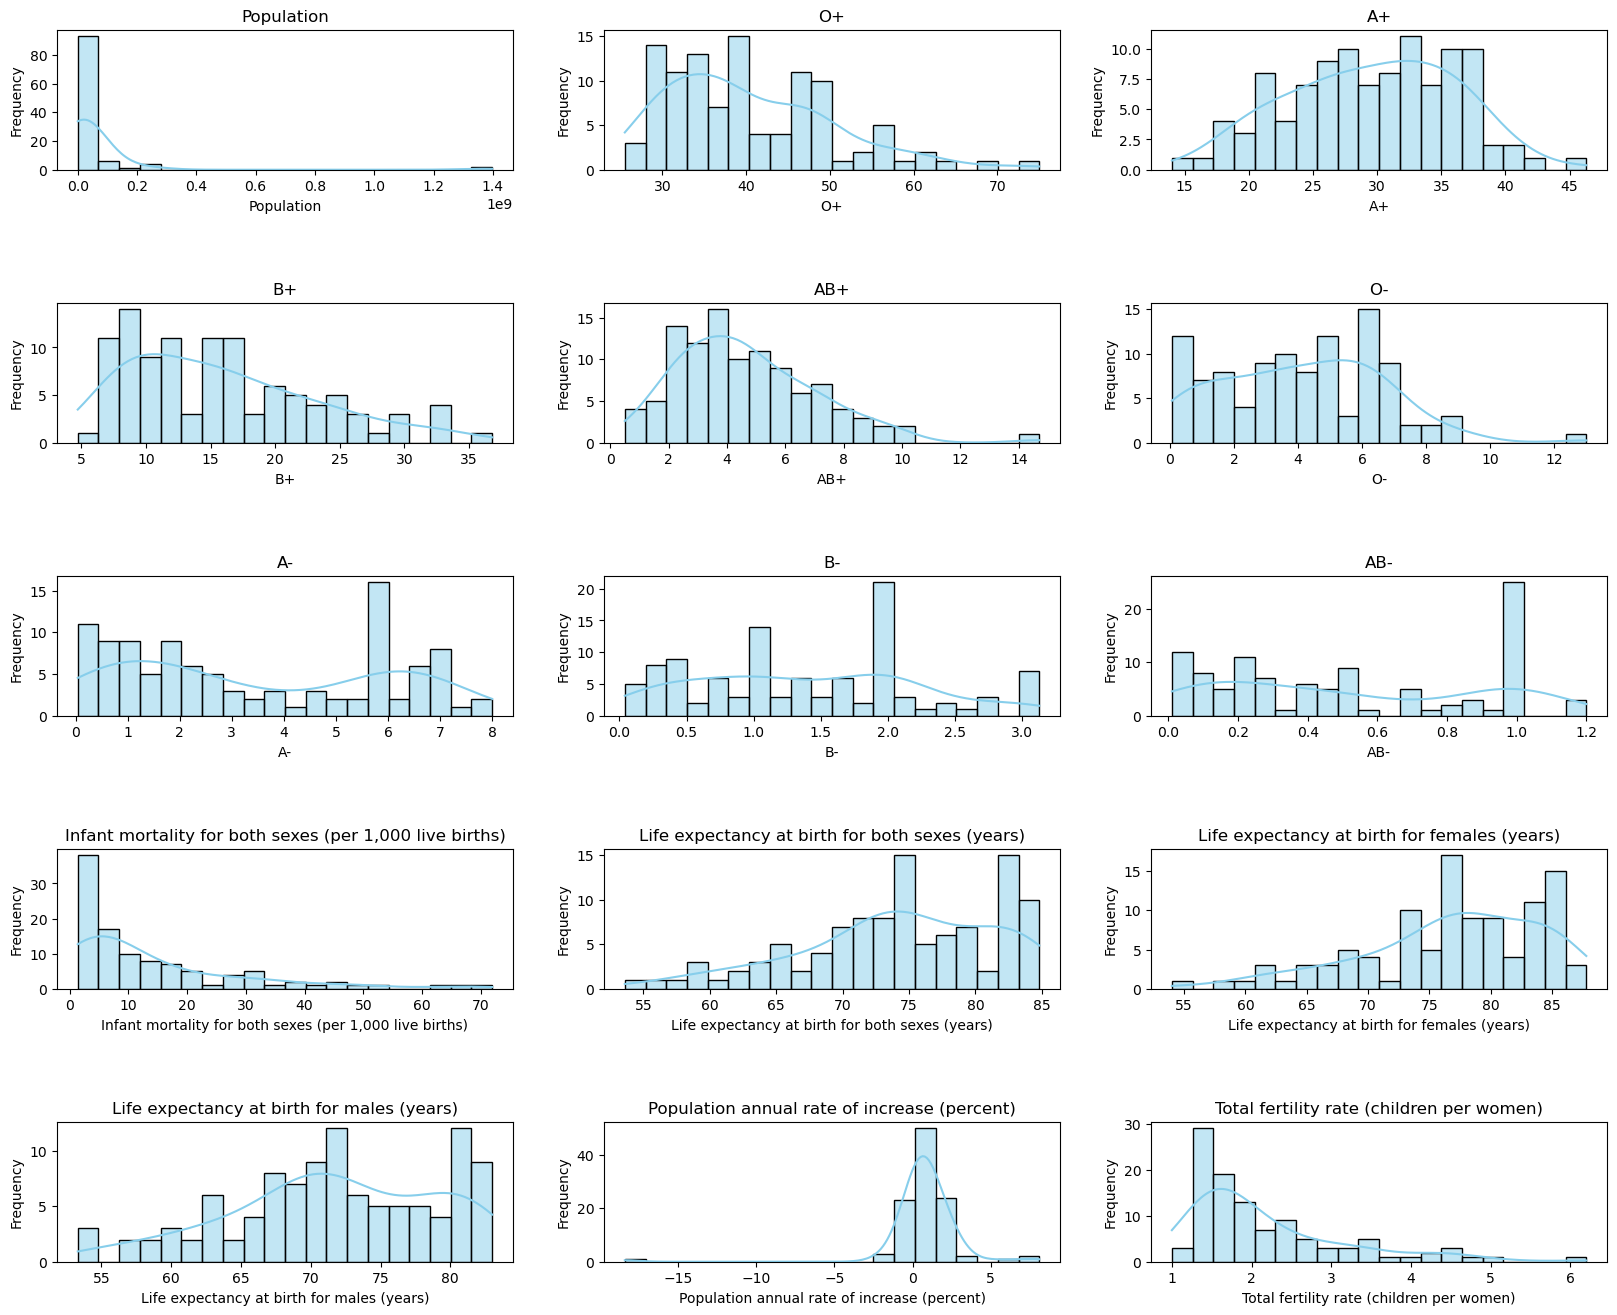

In [10]:
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))
fig.subplots_adjust(hspace=0.95)

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    
    sns.histplot(merged_df[column], bins=20, kde=True, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'{column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

for i in range(len(numerical_columns), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.show()

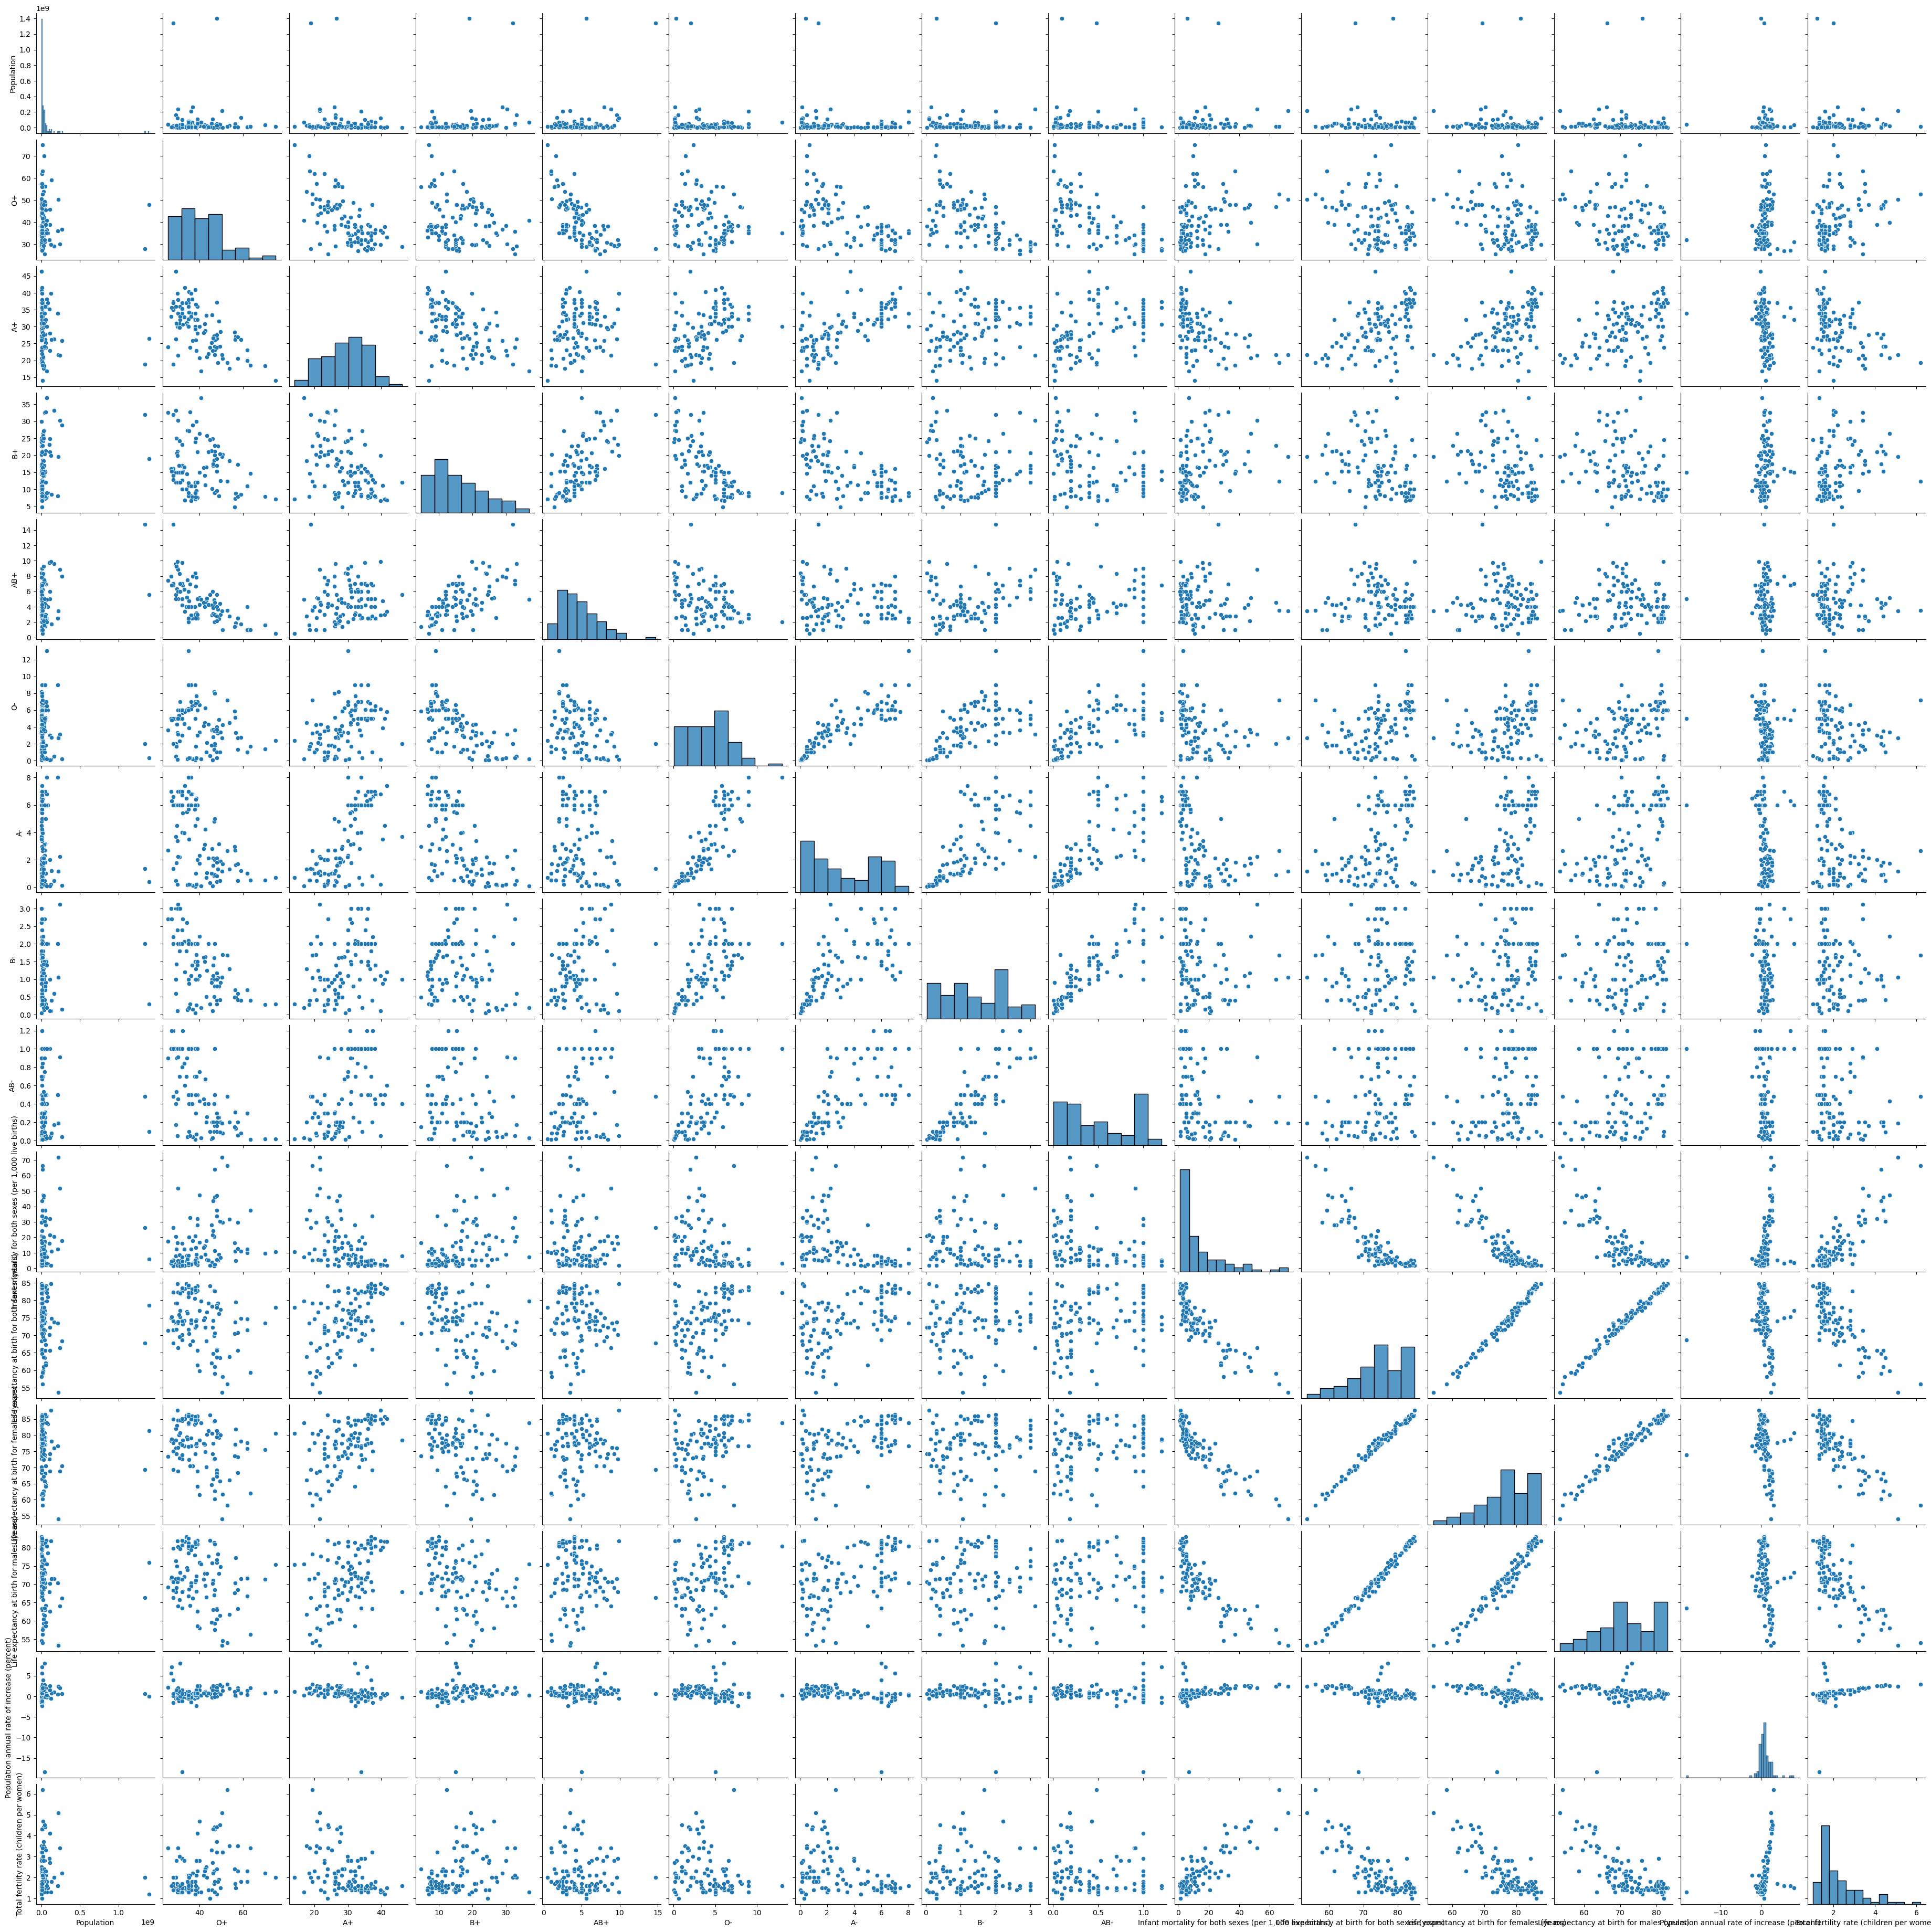

In [11]:
sns.pairplot(merged_df[['Population', 'O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-',
       'AB-',
       'Infant mortality for both sexes (per 1,000 live births)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for females (years)',
       'Life expectancy at birth for males (years)',
       'Population annual rate of increase (percent)',
       'Total fertility rate (children per women)']])
plt.show()

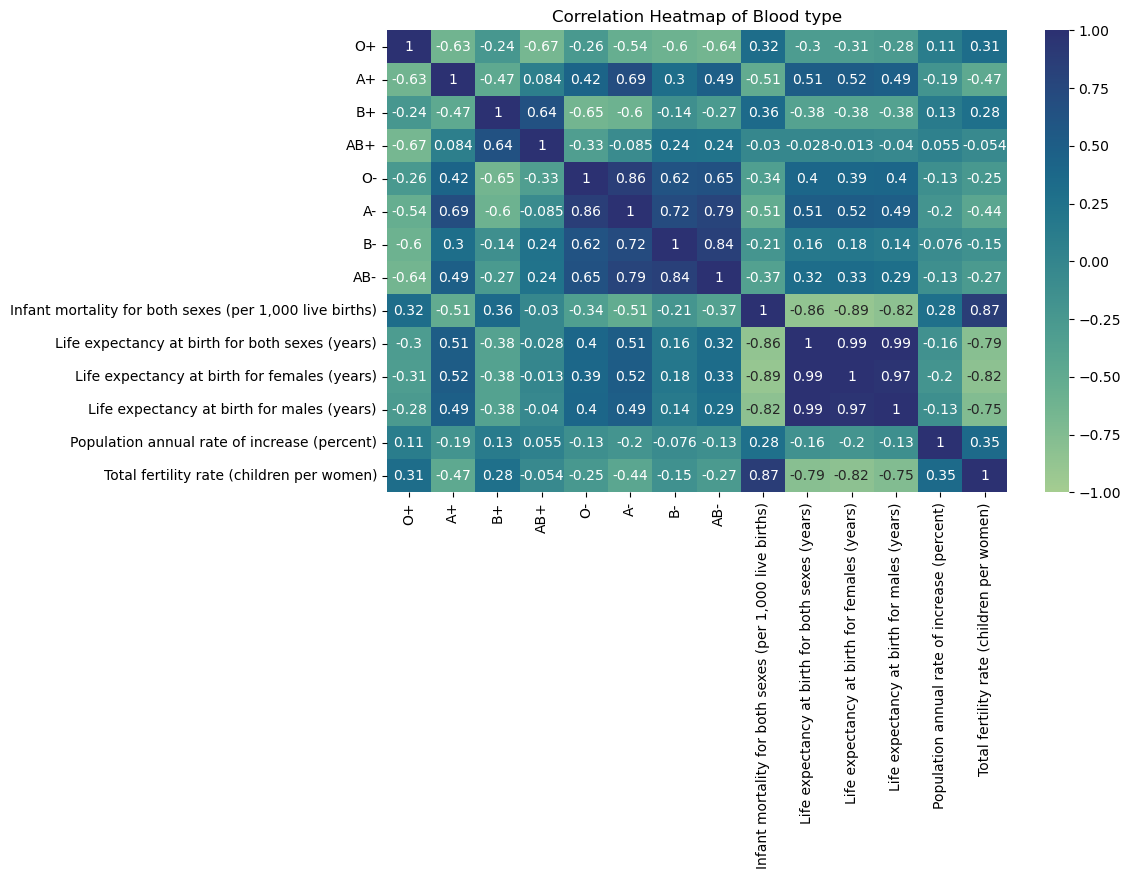

In [12]:
blood_type_columns = ['O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-', 'AB-']
health_indicator_columns = [
    'Infant mortality for both sexes (per 1,000 live births)',
    'Life expectancy at birth for both sexes (years)',
    'Life expectancy at birth for females (years)',
    'Life expectancy at birth for males (years)',
    'Population annual rate of increase (percent)',
    'Total fertility rate (children per women)'
]

correlation_matrix = merged_df[blood_type_columns + health_indicator_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='crest',vmin=-1.0,vmax=1.0)
plt.title('Correlation Heatmap of Blood type')
plt.show()

## Data verification

In [13]:
merged_df.isnull().sum()

Country                                                    0
Population                                                 0
O+                                                         0
A+                                                         0
B+                                                         0
AB+                                                        0
O-                                                         1
A-                                                         1
B-                                                         1
AB-                                                        1
Year                                                       0
Infant mortality for both sexes (per 1,000 live births)    0
Life expectancy at birth for both sexes (years)            0
Life expectancy at birth for females (years)               0
Life expectancy at birth for males (years)                 0
Population annual rate of increase (percent)               0
Total fertility rate (ch

In [14]:
merged_df['O-'].fillna(merged_df['O-'].mode()[0], inplace=True)
merged_df['A-'].fillna(merged_df['A-'].mode()[0], inplace=True)
merged_df['B-'].fillna(merged_df['B-'].mode()[0], inplace=True)
merged_df['AB-'].fillna(merged_df['AB-'].mode()[0], inplace=True)

# Data Preprocessing

## Standarization

In [15]:
scaled_df = merged_df.copy()
scaler = StandardScaler()
scaled_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])
scaled_df.head(10)

Country  Population        O+        A+        B+       AB+        O-  \
0     Albania   -0.292467 -0.635066  0.247888 -0.190857  0.222290  0.752288   
1     Algeria   -0.077735 -0.047049  0.062213 -0.122017 -0.176936  0.991611   
2   Argentina   -0.067649  0.839960  0.300496 -1.085785 -0.933365  0.313529   
3     Armenia   -0.292749 -1.143351  2.584300 -0.535060  0.390385 -0.843201   
4   Australia   -0.173751 -0.246377  0.062213 -0.535060 -0.281996  1.151160   
5     Austria   -0.261797 -1.043688  1.300047 -0.535060  0.138242  0.752288   
6  Azerbaijan   -0.254659 -1.063620  0.062213  0.717838  1.819195 -0.324667   
7     Bahrain   -0.300788  0.798101 -1.585654  0.925737 -0.420674 -0.336633   
8  Bangladesh    0.561240 -1.122422 -0.510286  2.372766  2.067135 -1.429543   
9     Belarus   -0.258709 -0.814461  0.155050 -0.080712  0.894671  0.632626   

         A-        B-       AB-  Year  \
0  0.814198  1.461306  1.005467  2022   
1 -0.466470 -0.367051  0.607585  2022   
2 -0.122290 -0.732723 -0.718692  2022   
3  0.093823 -0.488942 -0.320809  2022   
4  1.014303  0.729963  1.270723  2022   
5  1.414512  0.729963 -0.188181  2022   
6 -0.026240  1.217525  1.270723  2022   
7 -0.854672 -0.440186 -0.718692  2022   
8 -1.194850 -0.976504 -0.930896  2022   
9  0.774178  1.583196  1.801233  2022   

   Infant mortality for both sexes (per 1,000 live births)  \
0                                          -0.380774         
1                                           0.175031         
2                                          -0.341073         
3                                          -0.387390         
4                                          -0.738076         
5                                          -0.757927         
6                                           0.161798         
7                                          -0.566042         
8                                           0.426466         
9                                          -0.797627         

   Life expectancy at birth for both sexes (years)  \
0                                         0.354568   
1                                         0.395749   
2                                         0.258480   
3                                        -0.112146   
4                                         1.287996   
5                                         1.123274   
6                                        -0.098419   
7                                         0.684013   
8                                        -0.070965   
9                                        -0.139600   

   Life expectancy at birth for females (years)  \
0                                      0.366156   
1                                      0.228377   
2                                      0.338600   
3                                      0.214599   
4                                      1.192836   
5                                      1.068834   
6                                     -0.088517   
7                                      0.503936   
8                                     -0.116073   
9                                      0.214599   

   Life expectancy at birth for males (years)  \
0                                    0.387136   
1                                    0.576306   
2                                    0.170942   
3                                   -0.504667   
4                                    1.360012   
5                                    1.157329   
6                                   -0.139838   
7                                    0.887086   
8                                   -0.018229   
9                                   -0.477642   

   Population annual rate of increase (percent)  \
0                                     -0.492479   
1                                      0.349501   
2                                     -0.113588   
3                                     -0.408281   
4                                      0.096907  

## Feature selection

In [47]:
features = scaled_df[['O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-','AB-']]

# Model Selection

# Hierarchical Clustering

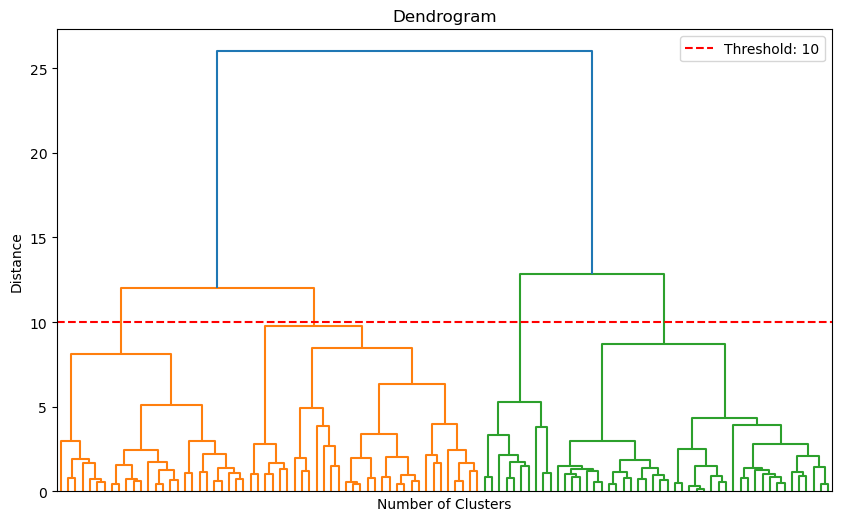

In [59]:
linkage_matrix = linkage(features, method='ward')  
threshold = 10
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, p=20, truncate_mode='level', orientation='top', show_contracted=True, no_labels=True)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')

# Show the legend to indicate the threshold
plt.legend()
plt.title('Dendrogram')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.show()

In [49]:
hierarchical_n_clusters = 4

## Kmeans clustering

#### 1. Elbow method

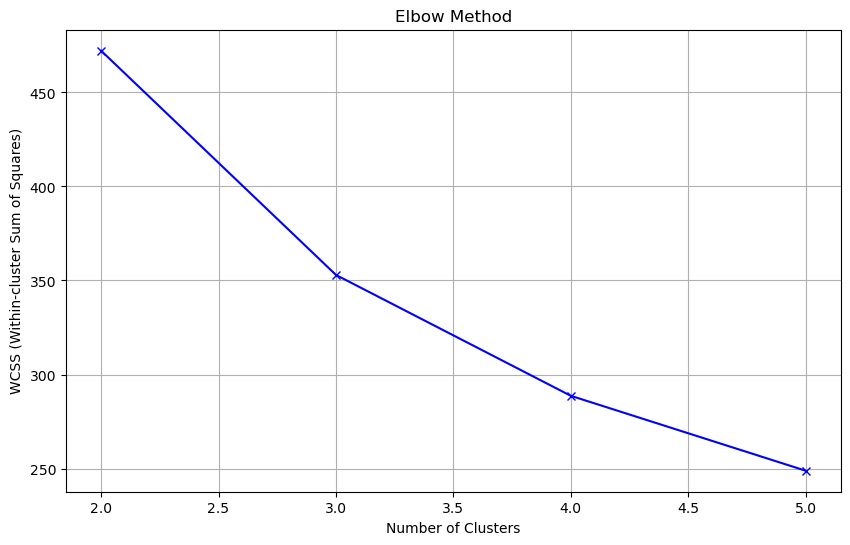

In [50]:
K = range(2, 6)
wcss = []
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
    
    
plt.figure(figsize=(10,6))
plt.plot(K, wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

#### 2. Silhouette score

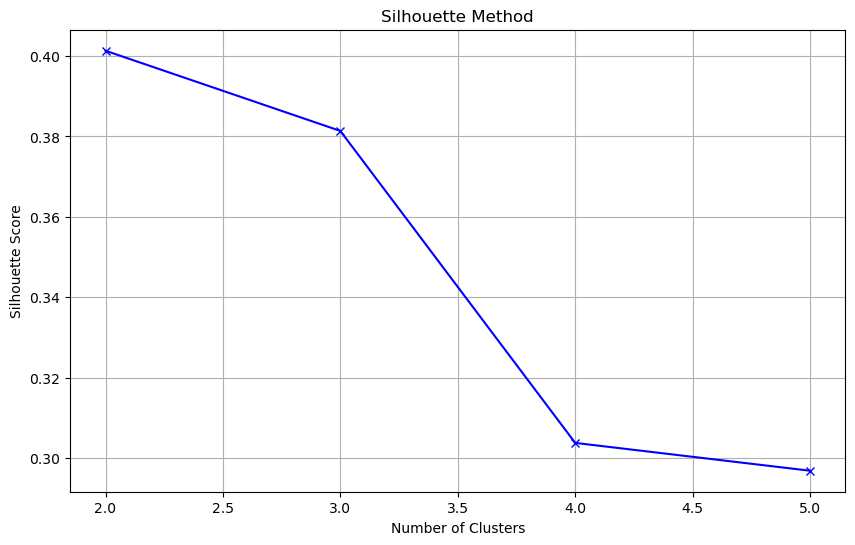

In [51]:
K = range(2,6)
silhouette_scores = []

for i in K:
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(features)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))


plt.figure(figsize=(10,6))
plt.plot(K, silhouette_scores, 'bx-')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [52]:
kmeans_n_clusters = 3

## GMM

#### 1. Bayesian Information Criterion (BIC)

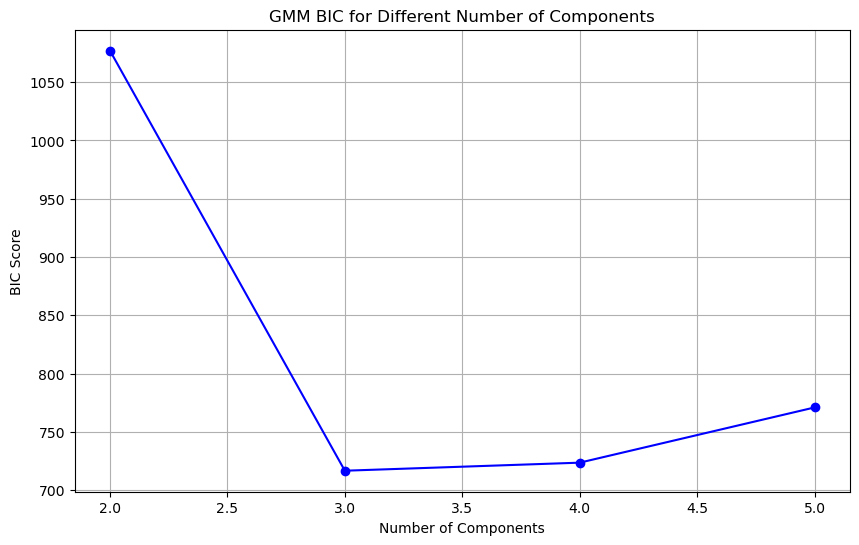

In [53]:
n_components = range(2, 6) 
bics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(features)
    bics.append(gmm.bic(features))

plt.figure(figsize=(10, 6))
plt.plot(n_components, bics, marker='o', linestyle='-', color='b')
plt.title('GMM BIC for Different Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

#### 2. Akaike Information Criterion (AIC)

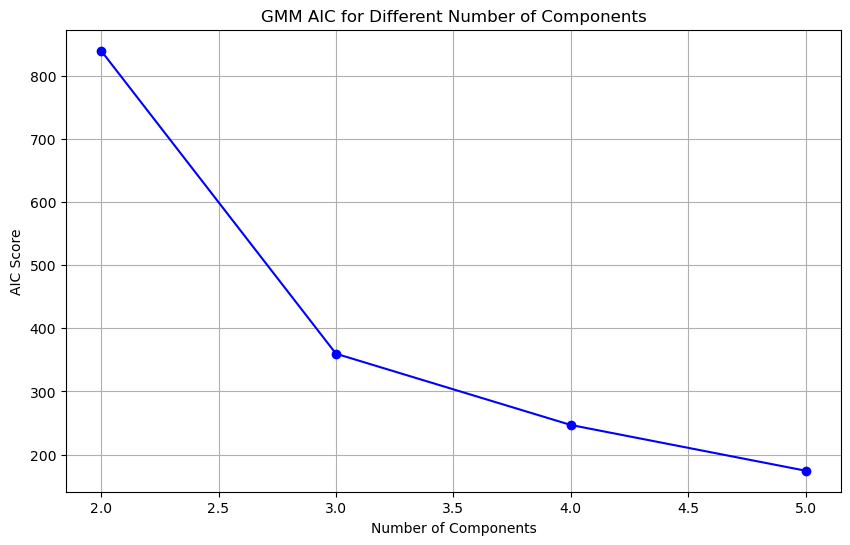

In [54]:
n_components = range(2, 6)
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(features)
    aics.append(gmm.aic(features))

plt.figure(figsize=(10, 6))
plt.plot(n_components, aics, marker='o', linestyle='-', color='b')
plt.title('GMM AIC for Different Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.grid(True)
plt.show()

In [55]:

gmm_n_clusters = 4

## Evalutaing each model  to select optimum model

In [25]:
cluster_methods = {
    "Hierarchical Clustering": AgglomerativeClustering(n_clusters=hierarchical_n_clusters, linkage='ward'),
    "K-Means": KMeans(n_clusters=kmeans_n_clusters, random_state=0),
    "GMM": GaussianMixture(n_components=gmm_n_clusters, random_state=0)
}

In [26]:
scores_df = pd.DataFrame(columns=["Method", "Silhouette Score", "CH Score"])

for method_name, cluster_method in cluster_methods.items():
    cluster_labels = cluster_method.fit_predict(features)
    
    silhouette = round(silhouette_score(features, cluster_labels), 2)
    
    ch_score = round(calinski_harabasz_score(features, cluster_labels), 2)
    
    scores_df = scores_df.append({"Method": method_name, "Silhouette Score": silhouette, "CH Score": ch_score}, ignore_index=True)

print("Clustering Evaluation Scores:")
scores_df

Clustering Evaluation Scores:


Method  Silhouette Score  CH Score
0  Hierarchical Clustering              0.26     47.10
1                  K-Means              0.38     72.23
2                      GMM              0.27     52.07

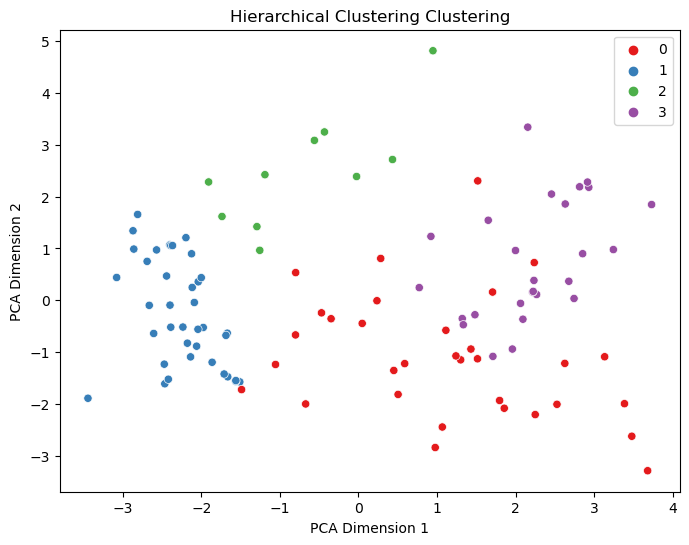

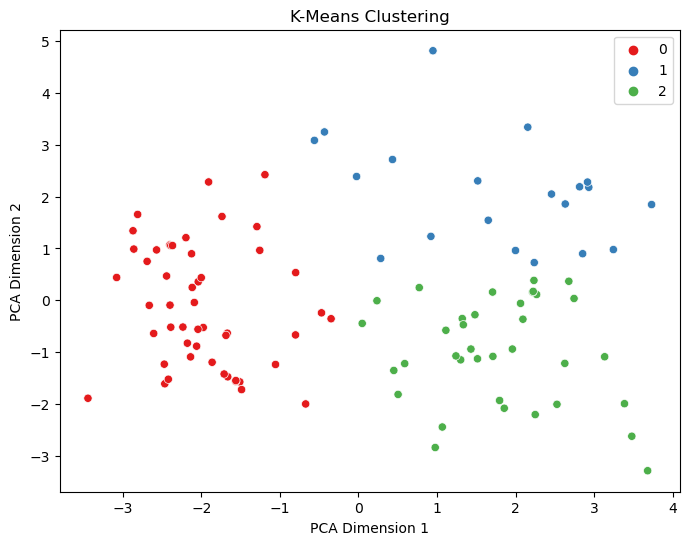

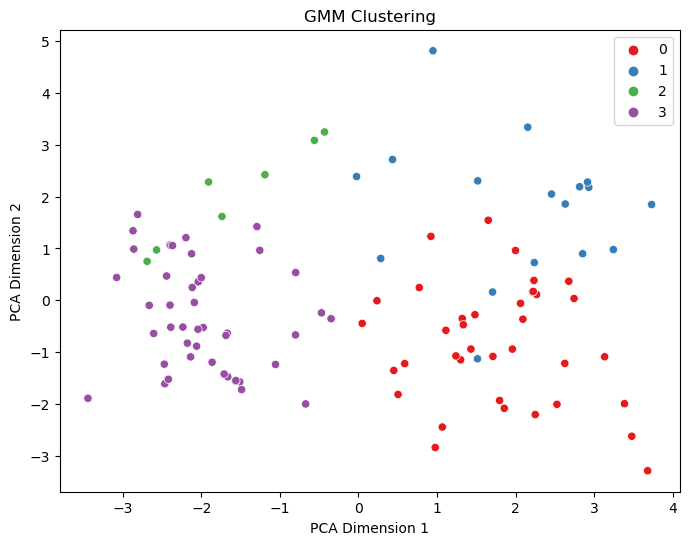

In [27]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

def plot_clusters(data, cluster_labels, method_name):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=cluster_labels, palette='Set1', legend='full')
    plt.title(f'{method_name} Clustering')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()
    
    

for method_name, cluster_method in cluster_methods.items():
    cluster_labels = cluster_method.fit_predict(features)
    plot_clusters(pca_features, cluster_labels, method_name)

# Model building

In [28]:
kmeans_n_clusters = 3
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=0)
kmeans_clusters = kmeans.fit_predict(features)

In [29]:
scaled_df['Cluster'] = kmeans_clusters
scaled_df.head()

Country  Population        O+        A+        B+       AB+        O-  \
0    Albania   -0.292467 -0.635066  0.247888 -0.190857  0.222290  0.752288   
1    Algeria   -0.077735 -0.047049  0.062213 -0.122017 -0.176936  0.991611   
2  Argentina   -0.067649  0.839960  0.300496 -1.085785 -0.933365  0.313529   
3    Armenia   -0.292749 -1.143351  2.584300 -0.535060  0.390385 -0.843201   
4  Australia   -0.173751 -0.246377  0.062213 -0.535060 -0.281996  1.151160   

         A-        B-       AB-  Year  \
0  0.814198  1.461306  1.005467  2022   
1 -0.466470 -0.367051  0.607585  2022   
2 -0.122290 -0.732723 -0.718692  2022   
3  0.093823 -0.488942 -0.320809  2022   
4  1.014303  0.729963  1.270723  2022   

   Infant mortality for both sexes (per 1,000 live births)  \
0                                          -0.380774         
1                                           0.175031         
2                                          -0.341073         
3                                          -0.387390         
4                                          -0.738076         

   Life expectancy at birth for both sexes (years)  \
0                                         0.354568   
1                                         0.395749   
2                                         0.258480   
3                                        -0.112146   
4                                         1.287996   

   Life expectancy at birth for females (years)  \
0                                      0.366156   
1                                      0.228377   
2                                      0.338600   
3                                      0.214599   
4                                      1.192836   

   Life expectancy at birth for males (years)  \
0                                    0.387136   
1                                    0.576306   
2                                    0.170942   
3                                   -0.504667   
4                                    1.360012   

   Population annual rate of increase (percent)  \
0                                     -0.492479   
1                                      0.349501   
2                                     -0.113588   
3                                     -0.408281   
4                                      0.096907   

   Total fertility rate (children per women)  Cluster  
0                                  -0.790552        0  
1                                   0.622917        0  
2                                  -0.285742        2  
3                                  -0.588628        0  
4                                  -0.588628        0

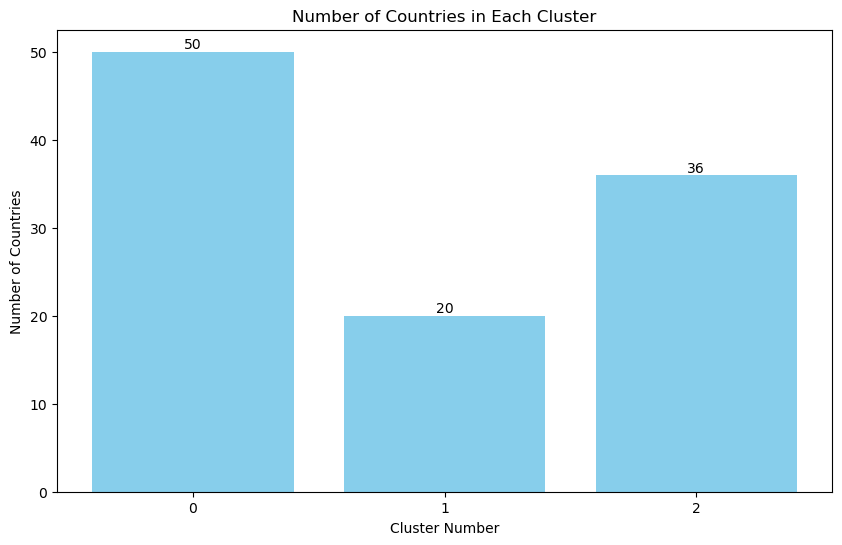

In [30]:
cluster_counts = scaled_df['Cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Countries')
plt.title('Number of Countries in Each Cluster')
plt.xticks(cluster_counts.index)

for i, count in enumerate(cluster_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


# Pairing

In [31]:
similarity_matrix = cosine_similarity(features)

similarity_threshold = 0.95

similar_country_pairs = []
for i in range(len(scaled_df)):
    for j in range(i + 1, len(scaled_df)):
        similarity = similarity_matrix[i, j]
        if similarity >= similarity_threshold:
            similar_country_pairs.append((scaled_df['Country'].iloc[i], scaled_df['Country'].iloc[j]))

print("Pairs of countries with similar blood type distribution:")
print(len(similar_country_pairs))
for pair in similar_country_pairs:
    print(pair,end=', ')


Pairs of countries with similar blood type distribution:
99
('Albania', 'Latvia'), ('Albania', 'North Macedonia'), ('Albania', 'Slovenia'), ('Argentina', 'Paraguay'), ('Australia', 'Lithuania'), ('Australia', 'New Zealand'), ('Bahrain', 'Nigeria'), ('Bangladesh', 'Mauritius'), ('Belarus', 'Latvia'), ('Belgium', 'Lithuania'), ('Bhutan', 'Indonesia'), ('Bhutan', 'Malaysia'), ('Bosnia and Herzegovina', 'Bulgaria'), ('Bosnia and Herzegovina', 'Romania'), ('Bosnia and Herzegovina', 'Sweden'), ('Bosnia and Herzegovina', 'Ukraine'), ('Brazil', 'Lebanon'), ('Brazil', 'Spain'), ('Bulgaria', 'Finland'), ('Bulgaria', 'Romania'), ('Bulgaria', 'Slovakia'), ('Bulgaria', 'Ukraine'), ('Cambodia', 'China'), ('Cambodia', 'Uganda'), ('Cameroon', 'Guinea'), ('Cameroon', 'Kenya'), ('Cameroon', 'Mauritania'), ('Cameroon', 'Singapore'), ('Cameroon', 'Uganda'), ('Canada', 'France'), ('Canada', 'Italy'), ('Canada', 'Netherlands'), ('Chile', 'Costa Rica'), ('Chile', 'Honduras'), ('Chile', 'Mexico'), ('China', '

In [32]:
paired_data = scaled_df[scaled_df['Country'].isin(sum(similar_country_pairs, ()))]

feature_columns = ['O+', 'A+', 'B+', 'AB+', 'O-', 'A-', 'B-', 'AB-']

tsne = TSNE(n_components=2, random_state=0)
tsne_representation = tsne.fit_transform(paired_data[feature_columns])

tsne_df = pd.DataFrame({'x': tsne_representation[:, 0], 'y': tsne_representation[:, 1], 'Country': paired_data['Country']})

fig = px.scatter(tsne_df, x='x', y='y', text='Country')

fig.update_traces(textposition='top right')  # Position annotations above the points

for country1, country2 in similar_country_pairs:
    pair_data = tsne_df[tsne_df['Country'].isin([country1, country2])]
    x1, y1 = pair_data.loc[pair_data['Country'] == country1, ['x', 'y']].values[0]
    x2, y2 = pair_data.loc[pair_data['Country'] == country2, ['x', 'y']].values[0]
    fig.add_shape(type='line',
                  x0=x1, y0=y1, x1=x2, y1=y2,
                  line=dict(color='red', dash='dash'))

fig.update_layout(title='Visualization of Paired Countries with Similar Blood Type Distributions')
fig.show()
